In [1]:
from pan import *

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from copy import deepcopy

import jax.numpy as jnp
from jax import grad, jit
from jax import random
import jax

import joblib

import matplotlib.pyplot as plt
from matplotlib import colorbar, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image, clear_output

# Prediction and Noise (PaN) can implement behavior that looks like reward optimization.

We show how PaN interacts with closed-loop bandit environments. Without any explicit instructions to optimize a global signal, PaN learns to take actions that maximize an input signal. It does so while autonomously balancing its behavior between discrete explore and exploit phases.

We define a bandit environment that takes the output layer activations $\mathbf{x_2}$ of a PaN network as input. It finds the argmax of the output layer and indexes a predefined vector (`reward_means`) with the argmax. We set the resulting environmental signal as the target for the PaN network's first layer.

#### Example bandit usage

In [2]:
def bandit(motors, rewards, key):
    '''Takes a set of motor outputs from network and finds argmax. 
    Returns corresponding reward from reward vector.
    '''
    lever_ind = jnp.argmax(motors)
    reward = jnp.array(rewards[lever_ind])
    return reward, lever_ind, key

In [3]:
# A random key is defined so that in the case of a tie, the bandit function chooses a random option between the tied activations.
key = random.PRNGKey(34587)

example_motor_activations = jnp.array([-1, 0, 2])
reward_means = jnp.array([0, 0, 1])

env_signal, chosen_index, key = bandit(example_motor_activations, reward_means, key)

print(f'\nThe network\'s current motor neuron activities are {example_motor_activations}.')
print(f'The possible environmental feedback signals are {reward_means}.')
print(f'\nThe chosen action index was {chosen_index}.')
print(f'The next signal from the environment is {env_signal}.')


The network's current motor neuron activities are [-1  0  2].
The possible environmental feedback signals are [0 0 1].

The chosen action index was 2.
The next signal from the environment is 1.


# PaN in simple bandit environment.

We start with a deterministic bandit environment with feedback signal vector [0, 0, 0.5]. That is, if the network chooses actions 0 or 1, it receives no input signal; if it chooses action 2, it receives a signal of 0.5.

#### Function definitions

In [4]:
# PaN simulation function
def run_PaN(hps, rewards, timesteps, settle_time=10, init_log=None, init_seed=None):
    '''Runs a PaN simulation and returns the logger with action, activity, and weight history.
    '''

    # Initialize network. If there's an init_log, load weights and activities from there.
    # Weights are random; acts are 0
    acts, weights, key = init_params(hps)

    if init_log is not None:
        acts = [jnp.array(init_log.acts[i][-1]) for i in range(len(init_log.acts))]
        weights = [jnp.array(init_log.weights[i][-1]) for i in range(len(init_log.weights))]
        key = random.PRNGKey(init_seed)

    # Initialize loggers
    log = Log(hps)

    ''' Simulation begins '''
    for t in range(timesteps):
        if t%10_000==0:
          clear_output(wait=True)
          print('Timestep', t)

        # Get outputs for bandit
        signal, lever, key = bandit(acts[-1], rewards, key)

        # Activities settle
        for j in range(settle_time):

          # Update activities
          acts = update_acts(signal, acts, weights, hps)
          # Add noise
          acts, key = act_noise(acts, key, hps)

        # Weight update
        weights = update_weights(signal, acts, weights, hps)
        # Add noise
        weights, key = weight_noise(weights, key, hps)
        weights = weight_clip(weights)

        # Log
        log.record(acts, weights, lever)
        log.record_energy(pred_loss, signal, acts, weights, hps)

    # Make objects in log easier to work with
    log.close()

    clear_output(wait=True)
    print('Done')
    return log


# Plotting functions
def plot_actions(log, legend_loc='right'):
    """Plots PaNs lever choices over time.
    """

    fig,ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [4, 1]});
    fig.set_size_inches((12,1.5));

    ax[0].plot(log.actions, label='Actions');
    window_size=1000
    rolling_avg = np.convolve(log.actions, np.ones(window_size) / window_size, mode='valid')
    ax[0].plot(np.arange(window_size//2, len(log.actions)-(window_size//2)+1), rolling_avg, label='Rolling average')
    ax[0].set_xlabel('Timesteps')
    ax[0].set_ylabel('Action choice');
    ax[0].set_title(f'{len(log.actions):,}-timestep run');
    ax[0].legend(loc=legend_loc);

    ax[1].set_title('First 50 timesteps');
    ax[1].plot(log.actions[:50]);
    ax[1].set_xlabel('Timesteps');

def plot_loss(log):
    """Plots PaNs predictive loss function over time.
    """

    plt.figure(figsize=(12,5));

    plt.plot(np.array(log.energy), label='Loss');
    plt.xlabel('Timesteps')
    plt.ylabel('Loss');
    plt.title(f'Predictive loss over time');
    plt.legend();

def plot_weights(log):
  """Plots PaNs weights over time.
  """

  fig, axs = plt.subplots(1, 2, figsize=(15, 5))

  axs[0].plot(log.weights[0].reshape(log.weights[0].shape[0], log.weights[0].shape[1] * log.weights[0].shape[2]));
  axs[0].set_xlabel('Timesteps')
  axs[0].set_title('Hidden Layer Weights')

  axs[0].set_ylabel("Weights")
  axs[1].plot(log.weights[1].reshape(log.weights[1].shape[0], log.weights[1].shape[1] * log.weights[1].shape[2]));
  axs[1].set_xlabel('Timesteps')
  axs[1].set_title('Motor Layer Weights')

  fig.suptitle(f'Weights over {len(log.actions):,}-timestep run')
  plt.tight_layout()

## PaN learns to choose actions that give nonzero feedback

In [5]:
# Set environmental feedback options
rewards = jnp.array([0., 0., 0.5])

# Set hyperparameters (empirically chosen)
timesteps = 30_000
settle_time = 10 # Number of activity update steps for every weight update step

hps = {

  'seed'       : 423976,
  'sizes'      : [1, 30, 3], # Number of neurons in each layer
  'init_scale' : 1.,         # Width of weight init distribution; default He

  # Learning parameters
  'alpha'  : 0.01, # Activity update rate
  'omega'  : 0.01, # Weight update rate

  # Network properties
  'eta_a'  : 0.01, # Activity noise scale
  'eta_w'  : 0.0001, # Weight noise scale
}

log1 = run_PaN(hps, rewards, timesteps, settle_time=settle_time)

Done


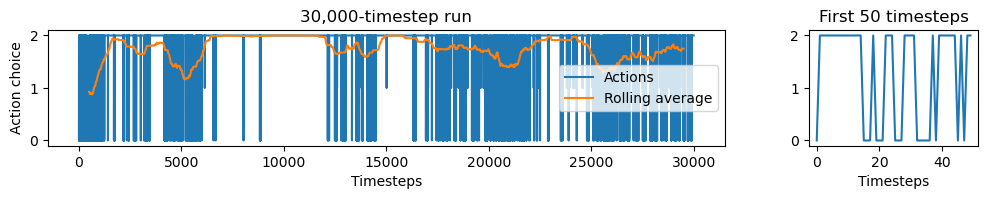

In [6]:
plot_actions(log1)

The network explored actions and learned to fixate more on the action corresponding to the highest environmental signal. We can try a different random seed to see how consistent this behavior is.

In [31]:
hps['seed'] = 3829
log2 = run_PaN(hps, rewards, timesteps, settle_time=settle_time)

Done


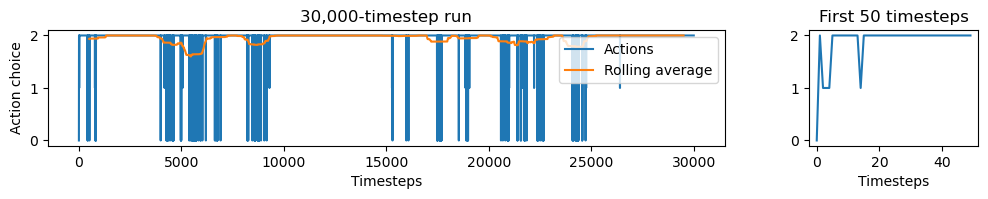

In [32]:
plot_actions(log2, legend_loc='upper right')

In terms of signal maximization, seed 3829 is more successful than seed 423977 (randomly chosen). But we can run the simulations for longer and over more seeds to see the general pattern of behavior. We tried 25 seeds over 500k timesteps each (run on compute cluster; see `Cluster scripts` folder for code). Shaded regions denote standard deviation.

In [7]:
def lever_bools(levers, rewards):
    '''Return N bools each of len(timesteps) for whether lever n was pulled
    '''
    lbools = []
    for l in range(len(rewards)):
        lbools.append(np.array(levers)==l)
    return lbools
    
def rolling_average(arr_list, window_size, interval=1000):
    '''GPT. 
    Takes a list of boolean arrays and a window size to average over; returns the average value for each array with a specified interval.'''
    ra_list = []
    for arr in arr_list:
        # Use slicing to skip intervals
        rolled = np.convolve(arr, np.ones(window_size)/window_size, mode='valid')[::interval]
        ra_list.append(rolled)
    return np.array(ra_list)

In [9]:
# Basic environment with one rewarding action
rewards = [0,0,.5]

# Get averaged action choices for all trials.
rollings = []
for seed in range(25):
    print(seed)
    clear_output(wait=True)
    fname = f'Noise sweep/levers_etaa7_etaw4_s{seed}_j10_IN.pkl'
    levers = joblib.load(f'./{fname}')
    lbools = lever_bools(levers, rewards)
    rollings.append(rolling_average(lbools, 5000))

24


In [11]:
rollings = np.array(rollings)
roll_mu = np.mean(rollings, axis=0)
roll_std = np.std(rollings, axis=0)

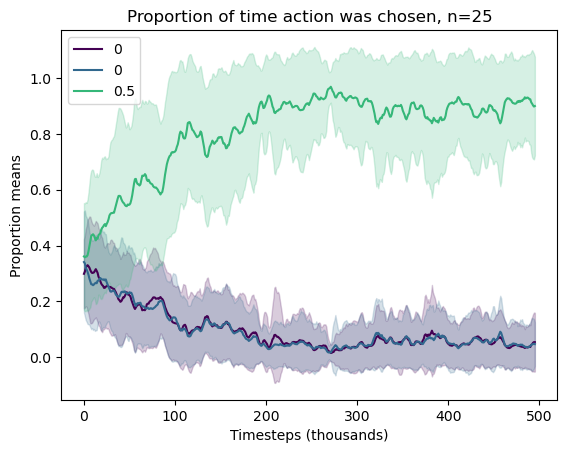

In [12]:
#GPT
# Plot means with shaded standard deviations, colored by 'n'
for i, n in enumerate(roll_mu):
    color = plt.cm.viridis(i / len(roll_mu))  # Use a colormap to color by 'n'
    plt.plot(range(roll_mu.shape[-1]), roll_mu[i], label=f'n = {n}', color=color)
    plt.fill_between(range(roll_mu.shape[-1]), roll_mu[i] - roll_std[i], roll_mu[i] + roll_std[i], color=color, alpha=0.2)

# Customize the plot
plt.xlabel('Timesteps (thousands)')
#plt.ylim(0,.5)
plt.ylabel('Proportion means')
plt.title('Proportion of time action was chosen, n=25')
# Make legend

# Create a legend skipping every other entry
handles, labels = plt.gca().get_legend_handles_labels()
skip_every_other = slice(None, None, 2)
plt.legend(handles, rewards)

PaN learns to take actions that lead to nonzero environmental signals. If the environmental signals are interpreted as reward values as in a standard reinforcement learning bandit task, then PaN demonstrates reward-seeking behavior.

### Intuition behind the behavior

Why does PaN choose actions that lead to nonzero environmental responses?

If the network chooses an action associated with 0 response, then the future behavior of the network will be dominated by internal noise, especially its actions. There is no input signal that can be multiplied by the network's weights, so all neuron activities fluctuate around 0. With fluctuating action choices, predictive errors can be relatively large: the difference in feedback possibilities (\~0.5) is much greater than the internal noise scale (\~0.01).

On the other hand, if the network receives nonzero feedback, it can fixate on the action depending on its weight values. Once it has learned to fixate for some time, contributions to the predictive loss come only from internal noise. This is the minimum loss state. The network can then choose actions with nonzero environmental responses while still occasionally being driven to explore by the persistent noise.

To illustrate, recall the first example seed. Notice that the loss magnitude decreases as PaN learns to fixate on the lever with a nonzero environmental signal.

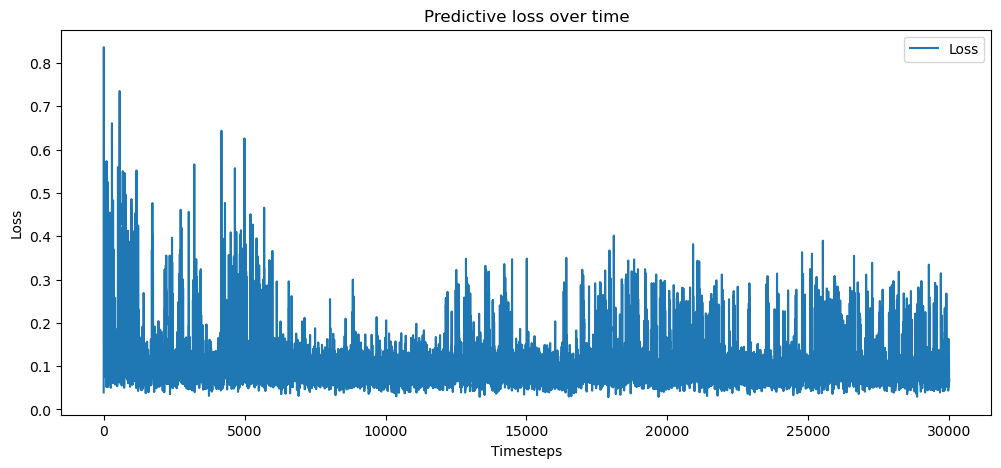

In [13]:
plot_loss(log1)

## PaN autonomously switches between explore and exploit phases.

If we look at a single 500k-step simulation, we see that PaN appears to have distinct periods of exploration and exploitation at increasing timescales.

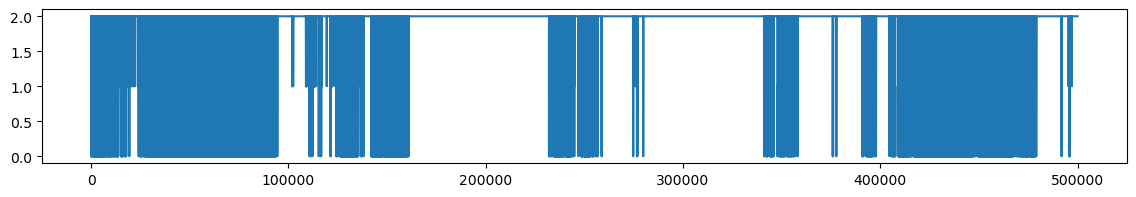

In [14]:
levers = joblib.load('Noise sweep/levers_etaa7_etaw4_s5_j10_IN.pkl')
plt.figure(figsize=(14,2));
plt.plot(levers);

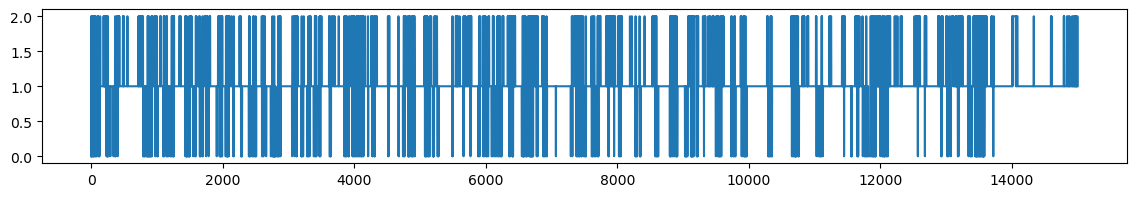

In [15]:
levers = joblib.load('Noise sweep/levers_etaa7_etaw4_s5_j10_IN.pkl')
plt.figure(figsize=(14,2));
plt.plot(levers[:15000]);

One way to quantify the exploration and exploitation phases is to calculate the entropy of PaN's lever choice distribution over a sliding window. During an exploitation phase, PaN sticks to a single lever, giving a lever choice distribution entropy of near zero. During an exploration phase, PaN chooses the three levers with nearly equal probability, leading to an entropy of about $log_2(3)$.


In [16]:
def sequence_entropy(sequence):
  """Computes the entropy of the distribution of any sequence of elements
  """

  # Get unique elements and their counts
  unique_elements, counts = np.unique(sequence, return_counts=True)

  # Compute probabilities
  probabilities = counts / len(sequence)

  # Compute entropy
  entropy = -np.sum(probabilities * np.log2(probabilities))

  return entropy

def sliding_window_view(data, window_size, step_size):
    for i in range(0, len(data) - window_size + 1, step_size):
        yield data[i:i+window_size]


def rolling_entropy(levers, window_size, step_size=None):
  """Computes the entropy of the lever choice distribution over a rolling window
     of length window_size. Step size is by default window size.
  """

  # Get sliding windows of whole lever sequence
  if step_size is None:
      step_size = window_size
  windows = np.array([s for s in sliding_window_view(levers, window_size, step_size)])

  # Get entropies of each window
  entropies = np.apply_along_axis(sequence_entropy, axis=1, arr=windows)

  return entropies


def plot_entropies(lever_data, timeframe, window_size=1000):
  """For easy plotting of PaN action entropy in provided dataset.
  """

  # Compute entropies
  entropies = rolling_entropy(lever_data[timeframe[0]:timeframe[1]], window_size)

  # Plot
  plt.figure(figsize=(12,3));
  plt.plot(entropies, label="Entropy");
  plt.xlabel('Timesteps')
  plt.ylabel('Lever Choice Entropy');
  plt.title(f'Timesteps {timeframe[0]:,} - {timeframe[1]:,}');
  plt.legend();
  return entropies
    

#### Results

To highlight that PaN has distinct explore and exploit phases, we contrast its behavior with what one might expect from an $\epsilon$-greedy agent that optimizes the same nonzero environmental signal with the same efficacy. Since the explore-exploit states emerge at increasing timescales, we show an illustrate example, pulled after ~450k timesteps.

PaN switches between distinct explore (high entropy) and exploit (low entropy) phases. This behavior is different from the $\epsilon$-greedy agent, which exhibits constant entropy because it selects the reward lever with probability $1 - \frac{2 \epsilon}{3}$ and the other two levers with probability $\frac{\epsilon}{3}$.

PaN is not simply "making mistakes" in its optimization of the environmental signal like an $\epsilon$-greedy algorithm, but rather autonomously alternating between phases of exploration and exploitation.

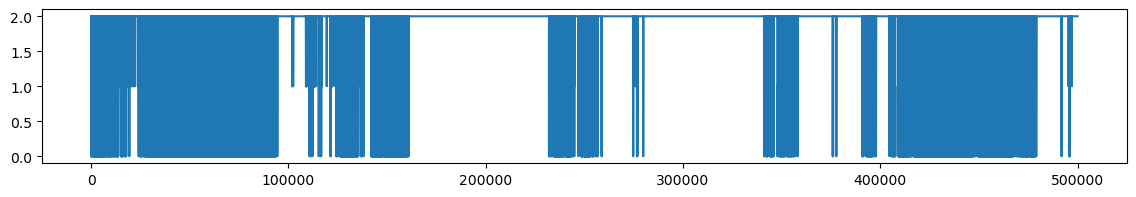

In [17]:
# Load data
folder_path = "Noise sweep/levers_etaa7_etaw4_s5_j10_IN.pkl"
levers = joblib.load(folder_path)
plt.figure(figsize=(14,2))
plt.plot(levers);

Feel free to play around with plotting the entropy of different agent's action choices over different time windows. Note that some agents do not show this behavior because they struggle to exploit the nonzero environmental signal in the first place.




In [18]:
######### Model of epsilon-greedy RL agent in 3 lever task ###############

# Set eps (0.15 gives 90% reward seeking which matches PaN agent)
eps = 0.15

# Set sim params
sim_length = 500_000
num_sims = 1

# Define prob of reward seeking step
p = 1 - 2 * eps / 3

# Generate data
rl_levers = np.random.choice([2, 1, 0], size=(num_sims, sim_length), p=[p, eps / 3, eps / 3])

# Get entropy
rl_entropies = rolling_entropy(rl_levers[0], window_size=1000)

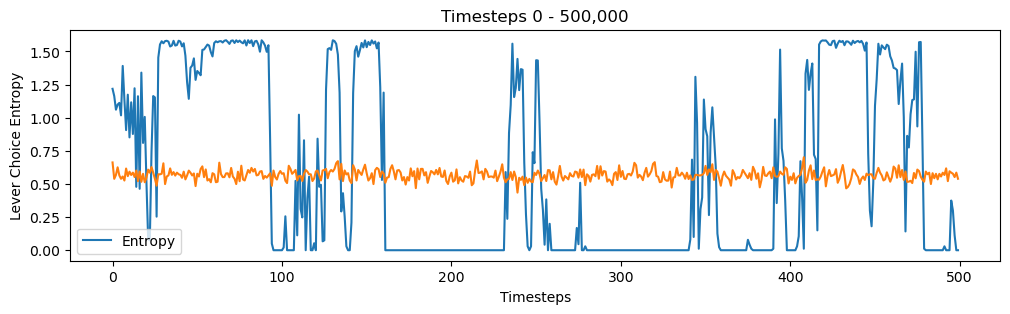

In [19]:
# Select agent number and timeframe
timeframe = [0, 500_000]

# Plot lever choice entropy
entropies = plot_entropies(levers, timeframe)
plt.plot(rl_entropies)

## Noise impacts reward-seeking and exploration/exploitation.

This behavior depends on the activity and weight noise variance. A "sweet spot" is required for robust reward-seeking behavior.

In [20]:
def reward_prop(levers, rewards):
    '''Calculates reward collected and divides by total possible reward in that timeframe.
    '''
    # Find maximum possible reward over t=len(levers)
    max_possible_reward = np.max(rewards) * len(levers)

    # Sum up rewards collected
    total_collected_reward = np.sum(np.array(rewards)[levers])

    # Return 0 if there is nonzero total possible reward (otherwise would throw inf)
    proportion = float(total_collected_reward / max_possible_reward) if max_possible_reward != 0 else 0
    return proportion

def jstats(j_index, prop_fun, prop_fun_input):
    '''Returns mean and standard dev. matrices of a given proportion function (exploit or reward).
    For a single activity settling time; covers all eta_a and eta_w values.
    j_index runs from 0 to 3 inclusive as in the blocks above.
    '''
    
    etas = np.array([0., 0.0001, 0.00024, 
                     0.00056, 0.0013, 0.0032,
                     0.0075, 0.018, 0.042, 0.1])
    n_seeds = 25
    
    # Initialize output matrices: means and stds
    jmean, jstd = np.zeros((len(etas), len(etas))), np.zeros((len(etas), len(etas)))
    
    # Loop over activity noise. This is COLUMNS
    for eta_ai in range(len(etas)):
        
        # Loop over weight noise. This is ROWS
        for eta_wi in range(len(etas)):
            
            print(eta_ai, eta_wi)
            clear_output(wait=True)
    
            # Set up a vector to store the function outputs for each seed
            seed_values = np.zeros(n_seeds)
            
            # Loop over seeds
            for s in range(n_seeds):
                
                # Load one file
                levers = joblib.load(f'Noise sweep/levers_etaa{eta_ai}_etaw{eta_wi}_s{s}_j10_IN.pkl')
                    
                # Evaluate proportion of _ function on this lever sequence
                prop = prop_fun(levers, prop_fun_input)
                seed_values[s] = prop
            
            # Fill in mean and std using seed_values vector
            jmean[eta_ai, eta_wi] = np.mean(seed_values)
            jstd[eta_ai, eta_wi]  = np.std(seed_values)
                
    return jmean, jstd

In [21]:
rewards = np.array([0., 0., 0.5])
j10_mu, j10_std = jstats(10, reward_prop, rewards)

9 9


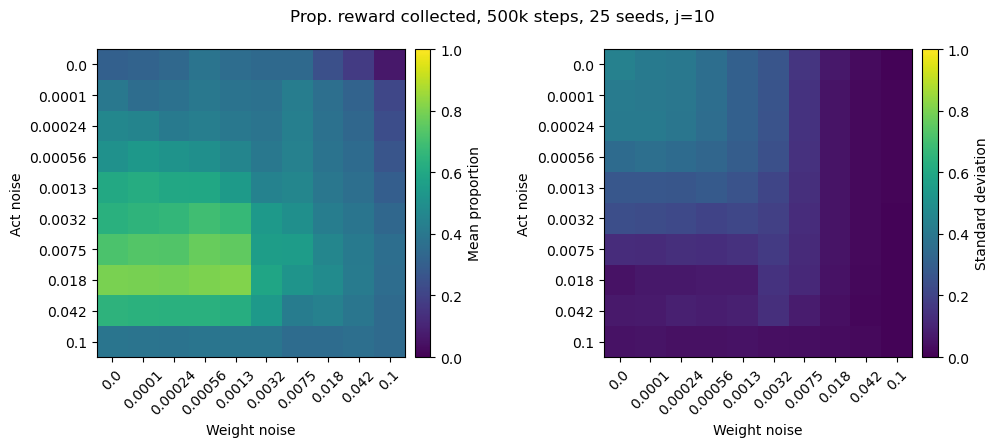

In [22]:
etas = np.array([0., 0.0001, 0.00024, 
                     0.00056, 0.0013, 0.0032,
                     0.0075, 0.018, 0.042, 0.1])

fig, ax = plt.subplots(1, 2)
fig.set_size_inches((12, 4))

# Assuming j10_mu and j10_std are 2D arrays
im0 = ax[0].imshow(j10_mu, vmin=0., vmax=1.)
im1 = ax[1].imshow(j10_std, vmin=0., vmax=1.)

for i in range(2):
    ax[i].set_xticks(range(10))
    ax[i].set_xticklabels(etas, rotation=45)
    ax[i].set_xlabel('Weight noise')
    
    ax[i].set_yticks(range(10))
    ax[i].set_yticklabels(etas)
    ax[i].set_ylabel('Act noise')
    
    # Add a colorbar for each subplot
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im0 if i == 0 else im1, cax=cax)
    cbar.set_label('Mean proportion' if i == 0 else 'Standard deviation')

fig.suptitle('Prop. reward collected, 500k steps, 25 seeds, j=10');

In [23]:
# Make an array to store the number of entries in the first entropy bin (high exploit)
num_seeds = 25
bins = np.concatenate([np.linspace(0, np.log2(3), 11), [1.6]])
exploits = np.zeros((10,10,num_seeds))

# Get all entropies for all seeds
window_size = 10_000

for etaa_i in range(10):
    for etaw_i in range(10):
        print(etaa_i, etaw_i)
        clear_output(wait=True)

        for s in range(num_seeds):
            
            # Get entropies for each random seed
            re = rolling_entropy(joblib.load(f'Noise sweep/levers_etaa{etaa_i}_etaw{etaw_i}_s{s}_j10_IN.pkl'), window_size, step_size=window_size)
            # Sort into histogram and convert first bin into percentage of bins
            hg = np.histogram(re, bins=bins)[0]

            exploits[etaa_i, etaw_i, s] = hg[0] / np.sum(hg)

9 9


In [24]:
j10_mu = np.mean(exploits, axis=2)
j10_std = np.std(exploits, axis=2)

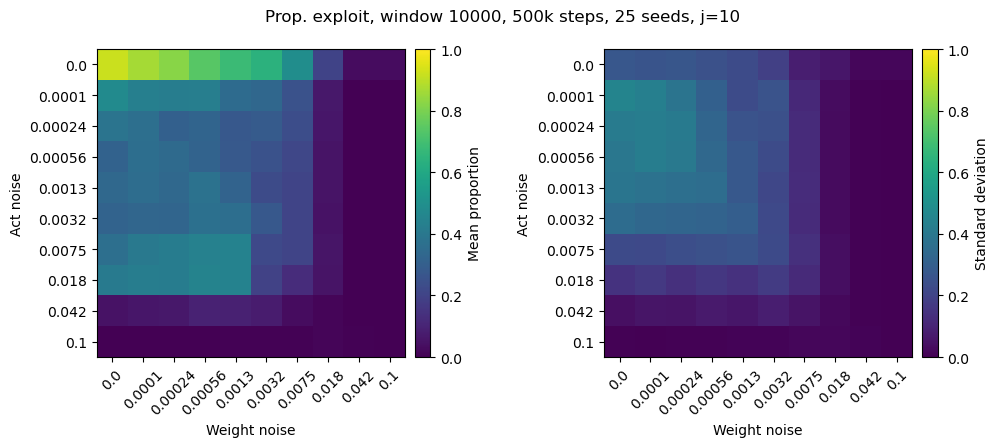

In [25]:
etas = np.array([0., 0.0001, 0.00024, 
                     0.00056, 0.0013, 0.0032,
                     0.0075, 0.018, 0.042, 0.1])

fig, ax = plt.subplots(1, 2)
fig.set_size_inches((12, 4))

# Assuming j10_mu and j10_std are 2D arrays
im0 = ax[0].imshow(j10_mu, vmin=0., vmax=1.)
im1 = ax[1].imshow(j10_std, vmin=0., vmax=1.)

for i in range(2):
    ax[i].set_xticks(range(10))
    ax[i].set_xticklabels(etas, rotation=45)
    ax[i].set_xlabel('Weight noise')
    
    ax[i].set_yticks(range(10))
    ax[i].set_yticklabels(etas)
    ax[i].set_ylabel('Act noise')
    
    # Add a colorbar for each subplot
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im0 if i == 0 else im1, cax=cax)
    cbar.set_label('Mean proportion' if i == 0 else 'Standard deviation')

fig.suptitle(f'Prop. exploit, window {window_size}, 500k steps, 25 seeds, j=10');

## No noise

In [26]:
# Basic environment with one rewarding action
rewards = [0,0,.5]

# Get averaged action choices for all trials.
rollings = []
for seed in range(25):
    print(seed)
    clear_output(wait=True)
    fname = f'Noise sweep/levers_etaa0_etaw0_s{seed}_j10_IN.pkl'
    levers = joblib.load(f'./{fname}')
    lbools = lever_bools(levers, rewards)
    rollings.append(rolling_average(lbools, 5000))

24


In [27]:
rollings = np.array(rollings)
roll_mu = np.mean(rollings, axis=0)
roll_std = np.std(rollings, axis=0)

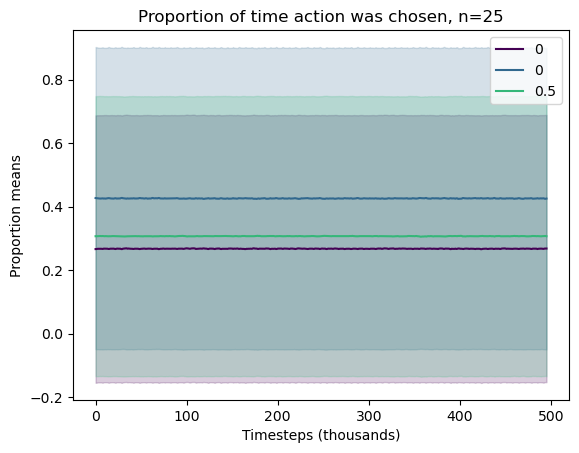

In [28]:
#GPT
# Plot means with shaded standard deviations, colored by 'n'
for i, n in enumerate(roll_mu):
    color = plt.cm.viridis(i / len(roll_mu))  # Use a colormap to color by 'n'
    plt.plot(range(roll_mu.shape[-1]), roll_mu[i], label=f'n = {n}', color=color)
    plt.fill_between(range(roll_mu.shape[-1]), roll_mu[i] - roll_std[i], roll_mu[i] + roll_std[i], color=color, alpha=0.2)

# Customize the plot
plt.xlabel('Timesteps (thousands)')
#plt.ylim(0,.5)
plt.ylabel('Proportion means')
plt.title('Proportion of time action was chosen, n=25')
# Make legend

# Create a legend skipping every other entry
handles, labels = plt.gca().get_legend_handles_labels()
skip_every_other = slice(None, None, 2)
plt.legend(handles, rewards)

## High weight noise

In [29]:
# Basic environment with one rewarding action
rewards = [0,0,.5]

# Get averaged action choices for all trials.
rollings = []
for seed in range(25):
    print(seed)
    clear_output(wait=True)
    fname = f'Noise sweep/levers_etaa0_etaw9_s{seed}_j10_IN.pkl'
    levers = joblib.load(f'./{fname}')
    lbools = lever_bools(levers, rewards)
    rollings.append(rolling_average(lbools, 5000))

24


In [30]:
rollings = np.array(rollings)
roll_mu = np.mean(rollings, axis=0)
roll_std = np.std(rollings, axis=0)

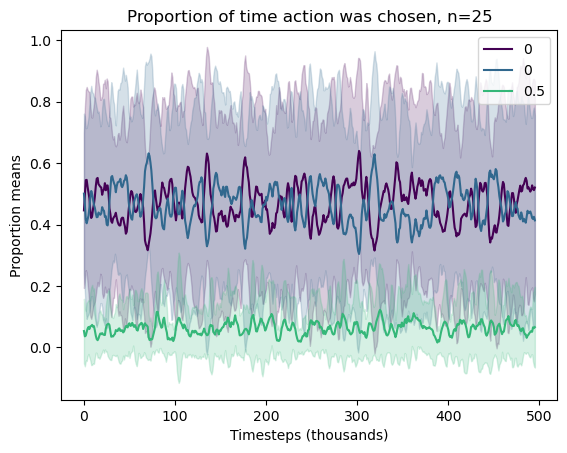

In [31]:
#GPT
# Plot means with shaded standard deviations, colored by 'n'
for i, n in enumerate(roll_mu):
    color = plt.cm.viridis(i / len(roll_mu))  # Use a colormap to color by 'n'
    plt.plot(range(roll_mu.shape[-1]), roll_mu[i], label=f'n = {n}', color=color)
    plt.fill_between(range(roll_mu.shape[-1]), roll_mu[i] - roll_std[i], roll_mu[i] + roll_std[i], color=color, alpha=0.2)

# Customize the plot
plt.xlabel('Timesteps (thousands)')
#plt.ylim(0,.5)
plt.ylabel('Proportion means')
plt.title('Proportion of time action was chosen, n=25')
# Make legend

# Create a legend skipping every other entry
handles, labels = plt.gca().get_legend_handles_labels()
skip_every_other = slice(None, None, 2)
plt.legend(handles, rewards)

## High noise overall

In [32]:
# Basic environment with one rewarding action
rewards = [0,0,.5]

# Get averaged action choices for all trials.
rollings = []
for seed in range(25):
    print(seed)
    clear_output(wait=True)
    fname = f'Noise sweep/levers_etaa9_etaw9_s{seed}_j10_IN.pkl'
    levers = joblib.load(f'./{fname}')
    lbools = lever_bools(levers, rewards)
    rollings.append(rolling_average(lbools, 5000))

24


In [33]:
rollings = np.array(rollings)
roll_mu = np.mean(rollings, axis=0)
roll_std = np.std(rollings, axis=0)

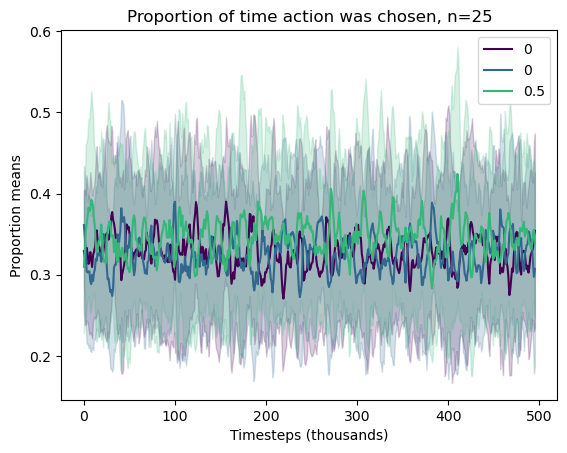

In [34]:
#GPT
# Plot means with shaded standard deviations, colored by 'n'
for i, n in enumerate(roll_mu):
    color = plt.cm.viridis(i / len(roll_mu))  # Use a colormap to color by 'n'
    plt.plot(range(roll_mu.shape[-1]), roll_mu[i], label=f'n = {n}', color=color)
    plt.fill_between(range(roll_mu.shape[-1]), roll_mu[i] - roll_std[i], roll_mu[i] + roll_std[i], color=color, alpha=0.2)

# Customize the plot
plt.xlabel('Timesteps (thousands)')
#plt.ylim(0,.5)
plt.ylabel('Proportion means')
plt.title('Proportion of time action was chosen, n=25')
# Make legend

# Create a legend skipping every other entry
handles, labels = plt.gca().get_legend_handles_labels()
skip_every_other = slice(None, None, 2)
plt.legend(handles, rewards)

# PaN maximizes reward in larger bandit tasks.

We explore PaN's behavior in a larger bandit environment with six levers and feedback signal vector [0, 0.1, 0.2, 0.3, 0.4, 0.5].

Note that in the manuscript, we run simulations to 500k timesteps.

In [40]:
# Set environmental feedback options
rewards = jnp.array([0., 0.1, 0.2, 0.3, 0.4, 0.5])

# Set hyperparameters (empirically chosen)
timesteps = 100_000
settle_time = 10 # Number of activity update steps for every weight update step

hps = {

  'seed'       : 3831,
  'sizes'      : [1, 30, 6], # Number of neurons in each layer
  'init_scale' : 1.,         # Width of weight init distribution; default He

  # Learning parameters
  'alpha'  : 0.01, # Activity update rate
  'omega'  : 0.01, # Weight update rate

  # Network properties
  'eta_a'  : 0.01, # Activity noise scale
  'eta_w'  : 0.0001, # Weight noise scale
}

log = run_PaN(hps, rewards, timesteps, settle_time=settle_time)

Done


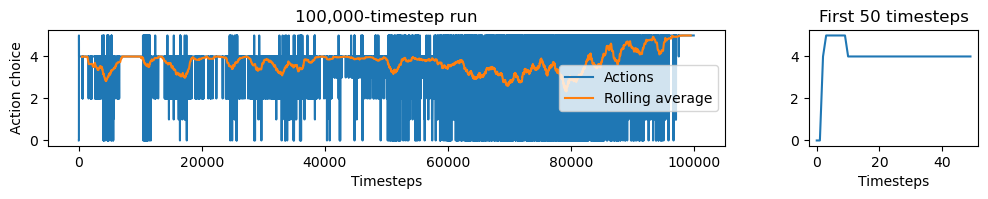

In [41]:
plot_actions(log)

### Weight decay explains reward maximization

Recall that PaN tends toward the state that minimizes its predictive loss. As before, the primary contributions to the predictive loss are the feedback signal fluctuations and the internal noise. PaN can reduce its feedback signal fluctuations by fixating on one action, and it can minimize its internal noise by shrinking its weights, since they are multiplicative factors for the activity noise that propagates to downstream layers.

However, these two contributions to the loss are in opposition. Fixating on one action requires increasing network weights enough to propagate an input signal that can consistently distinguish one maximally firing motor neuron. But increasing network weights also raises the internal noise.

Therefore, the minimal predictive loss state is the one that maintains small weights while still perserving enough signal for PaN to fixate on one action. Larger environmental inputs require smaller weights to achieve this. So to minimize the predictive loss, the network tends towards the largest input signal.

We confirm this intuition by observing the network weight decay that comes with the input signal maximization.

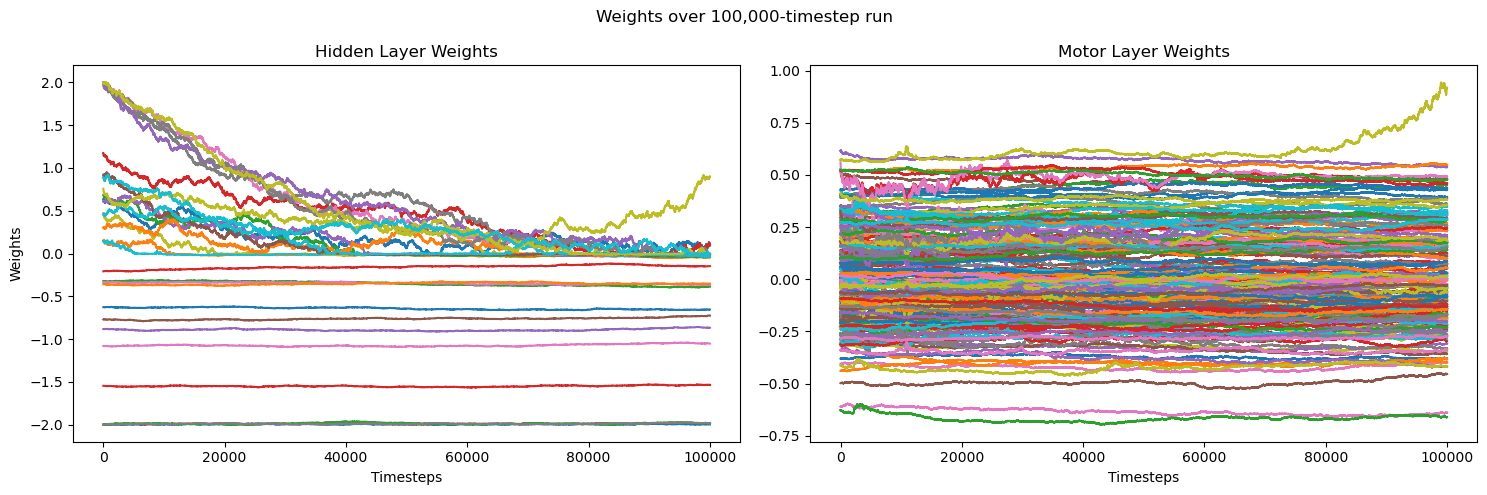

In [42]:
plot_weights(log)